<a href="https://colab.research.google.com/github/DmitriyKhodykin/USFinancials/blob/main/fit_evaluate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ПРОЕКТ: US Financials

Работа по созданию, обучению и оценки модели

## Пространство имен

In [1]:
!pip install catboost

In [2]:
# Импорты

## Постоянное хранилище данных
from google.colab import drive

## Таблицы и вычисления
import numpy as np
import pandas as pd

## Визуализация данных
import seaborn as sns
from seaborn import heatmap
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve

## Препроцессинг
import json
import warnings
from prettytable import PrettyTable
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import StratifiedShuffleSplit

## Модели
import sklearn
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

## Метрики
from sklearn.metrics import f1_score, make_scorer

In [3]:
# Хранение и загрузка данных
drive.mount('/content/drive')
work_dir = '/content/drive/My Drive/Models/USFinancials'
data_dir = '/content/drive/My Drive/Data/USFinancials'

Mounted at /content/drive


## Загрузка данных

In [4]:
data = pd.read_parquet(f'{data_dir}/data_for_baseline.parquet')
data

,researchDevelopment,effectOfAccountingCharges,incomeBeforeTax,minorityInterest,sellingGeneralAdministrative,grossProfit,ebit,operatingIncome,otherOperatingExpenses,interestExpense,extraordinaryItems,nonRecurring,incomeTaxExpense,totalRevenue,totalOperatingExpenses,costOfRevenue,totalOtherIncomeExpenseNet,discontinuedOperations,netIncomeFromContinuingOps,netIncomeApplicableToCommonShares,totalAssets,intangibleAssets,otherCurrentAssets,totalLiab,totalStockholderEquity,deferredLongTermLiab,otherCurrentLiab,commonStock,retainedEarnings,otherLiab,goodWill,otherAssets,cash,totalCurrentLiabilities,otherStockholderEquity,propertyPlantEquipment,totalCurrentAssets,netTangibleAssets,shortTermInvestments,netReceivables,longTermDebt,inventory,accountsPayable,noncontrollingInterestInConsolidatedEntity,commonStockTotalEquity,preferredStockTotalEquity,retainedEarningsTotalEquity,treasuryStock,nonCurrrentAssetsOther,nonCurrentAssetsTotal,longTermDebtTotal,nonCurrentLiabilitiesOther,nonCurrentLiabilitiesTotal,capitalSurpluse,liabilitiesAndStockholdersEquity,cashAndShortTermInvestments,commonStockSharesOutstanding,changeToLiabilities,totalCashflowsFromInvestingActivities,netBorrowings,totalCashFromFinancingActivities,changeInCash,totalCashFromOperatingActivities,depreciation,otherCashflowsFromInvestingActivities,dividendsPaid,changeToInventory,changeToAccountReceivables,salePurchaseOfStock,otherCashflowsFromFinancingActivities,changeToNetincome,capitalExpenditures,cashFlowsOtherOperating,cashAndCashEquivalentsChanges,name,y_1y,y_2y,y_3y,netIncome
37,0.0,0.0,12801000.0,0.0,15694000.0,32475000.0,20499000.0,16460000.0,321000.0,3659000.0,0.0,0.0,218000.0,225010000.0,16015000.0,192535000.0,-3659000.0,0.0,12583000.0,12583000.0,4.149700e+08,12987000.0,14137000.0,3.096550e+08,1.053150e+08,0.0,7000.0,304000.0,-79452000.0,19116000.0,7374000.0,13213000.0,57525000.0,129199000.0,-48590000.0,6.300000e+07,316053000.0,84954000.0,0.0,151196000.0,161300000.0,93195000.0,125982000.0,0.0,304000.0,0.0,-79452000.0,-9114000.0,3814000.0,9.891700e+07,161300000.0,19116000.0,180416000.0,242167000.0,4.149700e+08,57525000.0,30219278.0,3808000.0,-4647000.0,-1093000.0,-1093000.0,13398000.0,19138000.0,4392000.0,18000.0,0.0,-2503000.0,-3742000.0,0.0,-329000.0,5084000.0,4665000.0,-484000.0,12851000.0,CVGI,0.942995,0.691804,1.009845,12583000.0
38,0.0,0.0,17696000.0,0.0,14433000.0,35884000.0,25059000.0,21124000.0,327000.0,3428000.0,0.0,0.0,4501000.0,233391000.0,14760000.0,197507000.0,-3428000.0,0.0,13195000.0,13195000.0,4.012880e+08,13542000.0,13981000.0,3.067470e+08,9.454100e+07,0.0,173000.0,304000.0,-92035000.0,21051000.0,7658000.0,15506000.0,44674000.0,123551000.0,-46001000.0,6.221700e+07,300370000.0,73341000.0,0.0,150606000.0,162100000.0,91109000.0,120343000.0,0.0,304000.0,0.0,-92035000.0,-9114000.0,3562000.0,1.009180e+08,162100000.0,21051000.0,183151000.0,241387000.0,4.012880e+08,44674000.0,30219278.0,4950000.0,-3442000.0,-8594000.0,-8594000.0,8880000.0,20916000.0,4286000.0,0.0,0.0,1749000.0,-12450000.0,0.0,-329000.0,6736000.0,3442000.0,2450000.0,6766000.0,CVGI,1.103809,0.327134,1.059596,13195000.0
39,0.0,0.0,13526000.0,0.0,15304000.0,31121000.0,19298000.0,15485000.0,300000.0,1959000.0,0.0,0.0,3673000.0,215734000.0,15604000.0,184613000.0,-1959000.0,0.0,9853000.0,9853000.0,3.996420e+08,14121000.0,18385000.0,3.132420e+08,8.640000e+07,0.0,10000.0,304000.0,-105230000.0,22229000.0,7941000.0,19901000.0,37908000.0,120562000.0,-40103000.0,6.340000e+07,292753000.0,64338000.0,0.0,141823000.0,170451000.0,94637000.0,117363000.0,0.0,304000.0,0.0,-105230000.0,-9114000.0,3187000.0,1.068890e+08,170451000.0,22229000.0,192680000.0,240543000.0,3.996420e+08,37908000.0,30219278.0,-2105000.0,-1716000.0,6406000.0,6406000.0,-15325000.0,-20015000.0,4163000.0,0.0,0.0,5261000.0,-34884000.0,0.0,-329000.0,3125000.0,1716000.0,-5428000.0,-14336000.0,CVGI,1.191439,0.296144,1.021149,9853000.0
40,7700000.0,0.0,5625000.0,0.0,14243000.0,23211000.0,13900000.0,8638000.0,342000.0,4362000.0,0.0,0.0,12852000.0,18833

In [5]:
norm_data = pd.read_parquet(f'{data_dir}/norm_data_for_baseline.parquet')
norm_data

,researchDevelopment,effectOfAccountingCharges,incomeBeforeTax,minorityInterest,sellingGeneralAdministrative,grossProfit,ebit,operatingIncome,otherOperatingExpenses,interestExpense,extraordinaryItems,nonRecurring,incomeTaxExpense,totalRevenue,totalOperatingExpenses,costOfRevenue,totalOtherIncomeExpenseNet,discontinuedOperations,netIncomeFromContinuingOps,netIncomeApplicableToCommonShares,totalAssets,intangibleAssets,otherCurrentAssets,totalLiab,totalStockholderEquity,deferredLongTermLiab,otherCurrentLiab,commonStock,retainedEarnings,otherLiab,goodWill,otherAssets,cash,totalCurrentLiabilities,otherStockholderEquity,propertyPlantEquipment,totalCurrentAssets,netTangibleAssets,shortTermInvestments,netReceivables,longTermDebt,inventory,accountsPayable,noncontrollingInterestInConsolidatedEntity,commonStockTotalEquity,preferredStockTotalEquity,retainedEarningsTotalEquity,treasuryStock,nonCurrrentAssetsOther,nonCurrentAssetsTotal,longTermDebtTotal,nonCurrentLiabilitiesOther,nonCurrentLiabilitiesTotal,capitalSurpluse,liabilitiesAndStockholdersEquity,cashAndShortTermInvestments,commonStockSharesOutstanding,changeToLiabilities,totalCashflowsFromInvestingActivities,netBorrowings,totalCashFromFinancingActivities,changeInCash,totalCashFromOperatingActivities,depreciation,otherCashflowsFromInvestingActivities,dividendsPaid,changeToInventory,changeToAccountReceivables,salePurchaseOfStock,otherCashflowsFromFinancingActivities,changeToNetincome,capitalExpenditures,cashFlowsOtherOperating,cashAndCashEquivalentsChanges,netIncome,name,y_1y,y_2y,y_3y
0,0.0,0.0,0.805252,0.666667,0.352527,0.829422,0.833589,0.800709,0.762963,0.355574,0.0,0.0,0.140720,0.899539,0.348812,0.924457,0.844344,0.0,0.970032,0.970032,0.530707,0.000000,0.647000,0.038048,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.212646,0.874814,0.012166,0.037132,1.000000,1.000000,0.0,1.000000,0.000000,0.791853,0.864173,0.0,1.000000,0.0,1.000000,0.000000,0.146721,0.590678,0.000000,0.000000,0.000000,1.000000,0.530707,0.212646,1.000000,0.779338,0.860614,0.900725,0.900725,1.000000,0.956561,0.422625,0.910734,0.000000,0.491852,0.462817,0.000000,0.782837,0.512503,1.000000,0.314875,1.000000,0.970032,CVGI,0.942995,0.691804,1.009845
1,0.0,0.0,1.000000,0.666667,0.083600,1.000000,1.000000,1.000000,0.807407,0.307258,0.0,0.0,0.432021,1.000000,0.080248,1.000000,0.854171,0.0,1.000000,1.000000,0.293275,0.055422,0.634037,0.000000,0.768371,0.000000,0.003621,1.000000,0.748541,0.145390,0.176179,0.040300,0.073343,0.745696,0.135687,0.000000,0.651644,0.780048,0.0,0.988952,0.009019,0.717249,0.725141,0.0,1.000000,0.0,0.748541,0.000000,0.126616,0.605707,0.009019,0.145390,0.026811,0.957482,0.293275,0.073343,1.000000,0.809942,0.903603,0.801424,0.801424,0.945021,1.000000,0.309498,0.910067,0.000000,0.770142,0.333403,0.000000,0.782837,0.623846,0.585283,0.430761,0.924171,1.000000,CVGI,1.103809,0.327134,1.059596
2,0.0,0.0,0.834096,0.666667,0.269354,0.761671,0.789760,0.759048,0.607407,0.000000,0.0,0.0,0.375706,0.788349,0.260860,0.804093,0.916663,0.0,0.836353,0.836353,0.264711,0.113241,1.000000,0.084980,0.593348,0.000000,0.000065,1.000000,0.484852,0.233902,0.351737,0.117544,0.000000,0.677366,0.417080,0.056101,0.482452,0.609531,0.0,0.824486,0.103168,0.843425,0.651668,0.0,1.000000,0.0,0.484852,0.000000,0.096697,0.650554,0.103168,0.233902,0.120225,0.911475,0.264711,0.000000,1.000000,0.620876,0.965180,1.000000,1.000000,0.650474,0.000000,0.178228,0.910067,0.000000,1.000000,0.000000,0.000000,0.782837,0.380468,0.000000,0.119599,0.661204,0.836353,CVGI,1.191439,0.296144,1.021149
3,1.0,0.0,0.519753,0.666667,0.043080,0.365874,0.592767,0.466479,0.918519,0.502615,0.0,0.0,1.000000,0.459958,0.042799,0.508030,0.059855,0.0,0.000000,0.000000,0.000000,0.155882,0.701429,0.037930,0.342714,0.000000,0.662501,1.000000,0.287950,0.224585,0.416253,0.560635,0.155400,0.750086,0.363073,0.114431,0.080253,0.378670,0.0,0.202273,0.027711,1.000000,0.730294,0.0,1.000000,0.0,0.287950,0.000000,0.021621,0.000000,0.027711,0.227590,0.053789

## Подготовка к обучению

In [6]:
# Параметры, передаваемые в иксы
X = data.drop(['y_1y', 'y_2y', 'y_3y'], axis=1)

In [7]:
X.shape

(19812, 76)

In [8]:
# Параметры, передаваемые в иксы
X_norm = norm_data.drop(['y_1y', 'y_2y', 'y_3y'], axis=1)

In [9]:
X_norm.shape

(19812, 76)

In [10]:
# Посмотрим на реальную размерность иксов
np.linalg.matrix_rank(X_norm.iloc[:, :-1], tol=None, hermitian=False)

74

In [11]:
# Игреки
y_1 = data[['y_1y']]
y_2 = data[['y_2y']]
y_3 = data[['y_3y']]

In [12]:
y_1.shape

(19812, 1)

In [13]:
def get_bin_target(num: float):
    """Возвращает бинарный признак 1 и 0 для таргета"""
    if num >= 1.05:
        return 1
    else:
        return 0

In [14]:
# Бинарные игреки
y_1_bin = data['y_1y'].apply(get_bin_target)
y_2_bin = data['y_2y'].apply(get_bin_target)
y_3_bin = data['y_3y'].apply(get_bin_target)

## Сравнение моделей

In [15]:
# ГИПЕРПАРАМЕТРЫ
RANDOM_SEED = 42

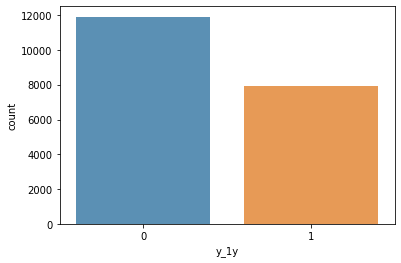

In [16]:
# Посмотрим на сбалансированность классов
warnings.filterwarnings('ignore')
sns.countplot(y_1_bin, alpha=0.8);

In [17]:
def review_classification(X, y, test_size):
    """Обзор метрик для некоторых моделей классификации на
    стандартных настройках
    """

    # Hold-out разбиение датасета
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=RANDOM_SEED
    )

    # CatBoost
    model_cb = CatBoostClassifier(random_state=RANDOM_SEED)
    model_cb.fit(X_train, y_train, silent=True)
    y_cb = model_cb.predict(X_test)
    f_cb = f1_score(y_test, y_cb)
    fi_cb = model_cb.get_feature_importance()

    # LightGBM
    model_lgb = LGBMClassifier(random_state=RANDOM_SEED)
    model_lgb.fit(X_train, y_train)
    y_lgb = model_lgb.predict(X_test)
    f_lgb = f1_score(y_test, y_lgb)
    fi_lgb = model_lgb.feature_importances_ / 25

    # XGBRegressor
    model_xgb = XGBClassifier(random_state=RANDOM_SEED)
    model_xgb.fit(X_train, y_train)
    y_xgb = model_xgb.predict(X_test)
    f_xgb = f1_score(y_test, y_xgb)
    fi_xgb = model_xgb.feature_importances_ * 100

    # RF
    model_rf = RandomForestClassifier(random_state=RANDOM_SEED)
    model_rf.fit(X_train, y_train)
    y_rf = model_rf.predict(X_test)
    f_rf = f1_score(y_test, y_rf)
    fi_rf = model_rf.feature_importances_ * 100

    # Метод опорных векторов
    model_svc = SVC(random_state=RANDOM_SEED, kernel='sigmoid')
    model_svc.fit(X_train, y_train)
    y_svc = model_svc.predict(X_test)
    f_svc = f1_score(y_test, y_svc)
    # importances_svc = model_svc.coef_
 
    # Таблица итогового сравнения
    results = pd.DataFrame({
        'Classifier': ['CatBoost', 'LGBM', 'XGB', 'RandomForest', 'SVC'], 
        'F1_Score': [f_cb, f_lgb, f_xgb, f_rf, f_svc],
        'Feature_Importances': [fi_cb, fi_lgb, fi_xgb, fi_rf, '']
    })

    sorted_results = results.sort_values(by=['F1_Score'], ascending=False)
  
    print(sorted_results)

    top_results = sorted_results.head(3)

    mean_feature_importances = np.mean(top_results['Feature_Importances'], 
                                       axis = 0)

    return mean_feature_importances

In [18]:
mean_feature_importances = review_classification(X.drop(['name'], axis=1), 
                                                 y_1_bin, 0.2)

     Classifier  F1_Score                                Feature_Importances
3  RandomForest  0.535963  [0.9592868790949736, 0.0, 1.238418418697832, 0...
0      CatBoost  0.452332  [2.096934417506705, 0.0, 0.4550886494757629, 1...
1          LGBM  0.445280  [1.72, 0.0, 0.56, 1.52, 1.8, 2.24, 1.16, 0.88,...
4           SVC  0.436269                                                   
2           XGB  0.260302  [2.2976549, 0.0, 1.3129569, 0.9224668, 1.70347...


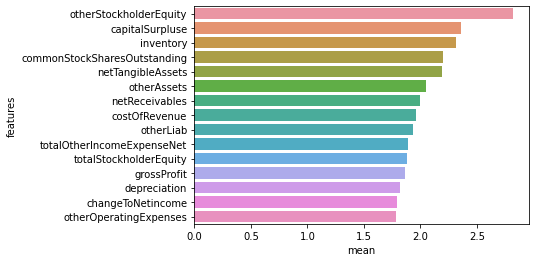

In [19]:
# Усредненные по первым трем моделям значения важности фичей
sns.barplot(x="mean", y="features", 
            data=pd.DataFrame({
                'mean': mean_feature_importances,
                'features': X.drop(['name'], axis=1).columns
                }).sort_values(by=['mean'], ascending=False)\
                  .iloc[:15, :],
            );

In [20]:
def best_features_reviev(X, y, test_size, feature_importances):
    """Печатает score на разных наборах лучших фичей
    """
    # Создадим список с индексами значимых фичей
    for i in [1.7, 1.8, 1.9, 2.0]:
        
        best_indx_list = []

        for indx, val in enumerate(feature_importances):
            if val >= i:  # Подбираем опытным путем
                best_indx_list.append(indx)
        
        best_cols_list = [X.columns[x] for x in best_indx_list]
        X_best = X[best_cols_list]
        print('Значение отсечки фичей по значимости:', i)
        review_classification(X_best, y_1_bin, 0.2)
        print('')


In [21]:
best_features_reviev(X.drop(['name'], axis=1), y_1_bin, 0.2, 
                     mean_feature_importances)

Значение отсечки фичей по значимости: 1.7
     Classifier  F1_Score                                Feature_Importances
3  RandomForest  0.563778  [5.037994146052359, 4.9563774384100086, 3.7068...
0      CatBoost  0.441152  [4.1097007151540375, 4.581707050021208, 4.7203...
1          LGBM  0.432886  [5.04, 5.24, 4.68, 6.56, 4.64, 5.24, 6.16, 6.3...
2           XGB  0.235722  [5.292769, 5.5033817, 3.71834, 4.777191, 4.942...
4           SVC  0.015019                                                   

Значение отсечки фичей по значимости: 1.8
     Classifier  F1_Score                                Feature_Importances
3  RandomForest  0.593571  [8.064124115143093, 8.0580542332553, 4.8644964...
0      CatBoost  0.456268  [7.737970451456896, 7.504346228706868, 6.13088...
1          LGBM  0.442244  [9.48, 9.52, 6.56, 9.0, 10.44, 9.96, 10.6, 8.1...
2           XGB  0.240365  [8.265875, 6.386558, 7.006617, 6.4735694, 6.37...
4           SVC  0.005076                                           

In [22]:
# Создадим список с индексами значимых фичей
best_indx_list = []

for indx, val in enumerate(mean_feature_importances):
    if val >= 1.9:  # Подобранное значение
        best_indx_list.append(indx)

In [23]:
best_indx_list

[15, 29, 31, 34, 37, 39, 41, 53, 56]

In [24]:
# Список наиболее значимых фичей
best_cols_list = [X.columns[x] for x in best_indx_list]

In [25]:
best_cols_list

['costOfRevenue',
 'otherLiab',
 'otherAssets',
 'otherStockholderEquity',
 'netTangibleAssets',
 'netReceivables',
 'inventory',
 'capitalSurpluse',
 'commonStockSharesOutstanding']

In [26]:
# Иксы с наиболее значимыми фичами
X_best = X[best_cols_list]
X_best_norm = X_norm[best_cols_list]

In [27]:
# Еще раз посмотрим на метрики на лучших фичах
review_classification(X_best, y_1_bin, 0.2)

     Classifier  F1_Score                                Feature_Importances
3  RandomForest  0.621855  [11.175331590831599, 11.117734184183762, 11.46...
0      CatBoost  0.462530  [9.589293970538142, 11.987021555893412, 11.566...
1          LGBM  0.413356  [11.32, 13.8, 14.28, 14.92, 13.28, 11.96, 10.4...
2           XGB  0.166208  [9.444802, 8.170248, 10.732487, 10.336745, 11....
4           SVC  0.003812                                                   


array([10.69487519, 12.30158525, 12.43791243, 12.78829016, 11.78187636,
       10.85842063,  9.60246751, 13.1619984 , 13.03924076])

## Валидация данных и оптимизация гиперпараметров

In [28]:
def train_cv(X, y, model, params: dict, scoring='f1'):
    """Возвращает результаты обучения модели на кросс-валидации,
    классы признаков балансируются перед подачей на вход модели
    """
    # Балансировка классов - Stratified
    sss = StratifiedShuffleSplit(n_splits=5, random_state=RANDOM_SEED)
    
    # Кросс-валидация на n-folds, сплошной перебор лучших параметров
    estimator = GridSearchCV(
        estimator=model, 
        param_grid=params, 
        scoring=scoring, 
        cv=sss,
        return_train_score=True
    )
    # Обучение переданной в Grid модели
    estimator.fit(X, y)
    
    # Результаты обучения - словарь со списками характеристик
    results = estimator.cv_results_
    print('Best Score:', estimator.best_score_)
    print('Best Params:') 
    print(json.dumps(estimator.best_params_, indent=4, sort_keys=True))

    return results

In [29]:
def plot_cv_results(cv_results, param_x, param_z, metric='mean_test_score'):
    """
    Визуализация результатов подбора параметров (сетки).
        cv_results - cv_results_ атрибут GridSearchCV с результатами обучения
        param_x - наименование параметра Grid для оси X
        param_z - наименование параметра Grid для визуализации в легенде
    """
    cv_results = pd.DataFrame(cv_results)
    col_x = 'param_' + param_x  # Ключ параметра `x`
    col_z = 'param_' + param_z  # Ключ параметра `z`
    fig, ax = plt.subplots(1, 1, figsize=(11, 8))
    
    # Дока: https://seaborn.pydata.org/generated/seaborn.pointplot.html
    sns.pointplot(
        x=col_x, y=metric, 
        hue=col_z, 
        data=cv_results, 
        ci=99, 
        n_boot=64, 
        ax=ax
    )
    
    ax.set_title("CV Grid Search Results")
    ax.set_xlabel(param_x)
    ax.set_ylabel(metric)
    ax.legend(title=param_z)
    
    return fig

### RF

In [66]:
# Словарь с параметрами для случайного леса
params_rf = {
    'n_estimators': [10, 100, 1000],    # Кол-во деревьев в лесу
    'criterion': ['gini'],              # Ф-я оценки качества деления
    'max_depth': [None],                # Макс глубина дерева
    'min_samples_split': [2, 4, 8],     # Мин кол-во выборок для деления 
    'min_samples_leaf': [1, 3],         # Мин кол-во выборок в листе
    'min_weight_fraction_leaf': [0.0],  # Веса образцов
    'max_features': ['sqrt'],           # Кол-во ф-ций при поиске сплита
    'max_leaf_nodes': [None],           # Ограничение кол-ва листовых узлов
    'min_impurity_decrease': [0.0],     # Уменьшение примеси
    'min_impurity_split': [None],       # Порог уменьшение примеси
    'bootstrap': [True],                # Бустрап включен
    'oob_score': [False],               # Нестандартные образцы
    'n_jobs': [-1],                     # Ограничение потоков, '-1' - все
    'random_state': [RANDOM_SEED],      # Сопоставимость результатов
    'verbose': [0],                     # Вывод в консоль хода обучения
    'warm_start': [False],              # Новый лес, или "прогретый" старт
    'class_weight': [None],             # Для задач с несколькими выходами y
    'ccp_alpha': [0.0],                 # Обрезка с мин затратами
    'max_samples': [None]               # Кол-во примеров для бутстрапа
}

In [ ]:
# RF
rfc = train_cv(X_best.loc[:, :], 
          y_1_bin.loc[:], 
          model=RandomForestClassifier(), 
          params=params_rf
      )

Best Score: 0.6329693950442523
Best Params:
{
    "bootstrap": true,
    "ccp_alpha": 0.0,
    "class_weight": null,
    "criterion": "gini",
    "max_depth": null,
    "max_features": "sqrt",
    "max_leaf_nodes": null,
    "max_samples": null,
    "min_impurity_decrease": 0.0,
    "min_impurity_split": null,
    "min_samples_leaf": 1,
    "min_samples_split": 2,
    "min_weight_fraction_leaf": 0.0,
    "n_estimators": 1000,
    "n_jobs": -1,
    "oob_score": false,
    "random_state": 42,
    "verbose": 0,
    "warm_start": false
}


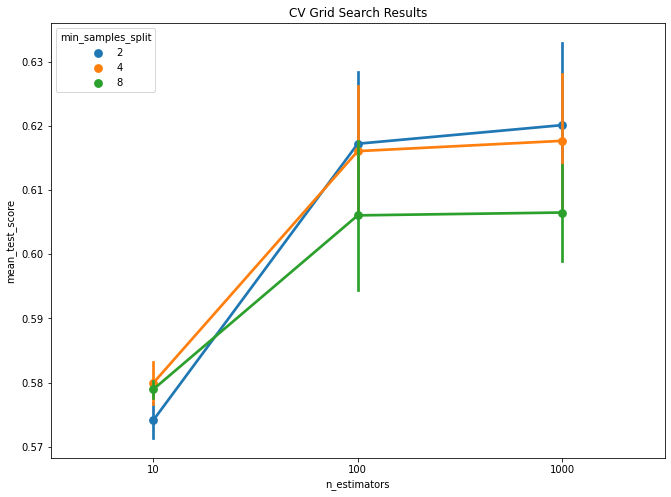

In [ ]:
# Оптимальное количество выборок для деления
plot_cv_results(rfc, 'n_estimators', 'min_samples_split');

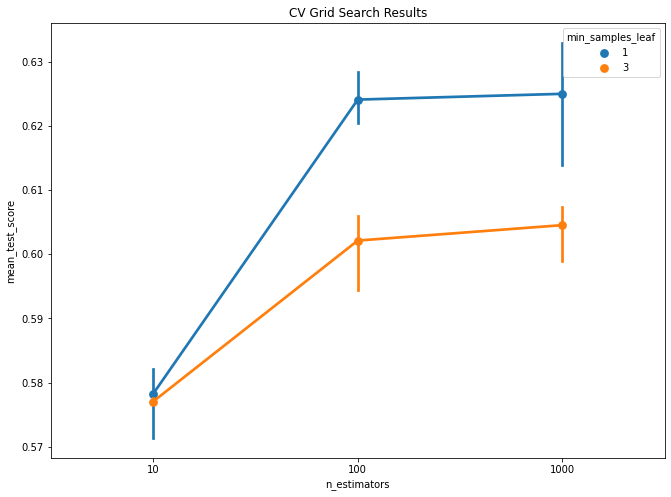

In [ ]:
# Оптимальное количество выборок в листе
plot_cv_results(rfc, 'n_estimators', 'min_samples_leaf');

### CB

In [30]:
# Датасет с лучшими признаками
# + категориальные признаки - тикеры
cat_df = X_best.copy()
cat_df['name'] = data['name'].values
cat_df.head()

,costOfRevenue,otherLiab,otherAssets,otherStockholderEquity,netTangibleAssets,netReceivables,inventory,capitalSurpluse,commonStockSharesOutstanding,name
37,192535000.0,19116000.0,13213000.0,-48590000.0,84954000.0,151196000.0,93195000.0,242167000.0,30219278.0,CVGI
38,197507000.0,21051000.0,15506000.0,-46001000.0,73341000.0,150606000.0,91109000.0,241387000.0,30219278.0,CVGI
39,184613000.0,22229000.0,19901000.0,-40103000.0,64338000.0,141823000.0,94637000.0,240543000.0,30219278.0,CVGI
40,165127000.0,22105000.0,45112000.0,-41235000.0,52149000.0,108595000.0,99015000.0,239870000.0,30219278.0,CVGI
41,173199000.0,23113000.0,53916000.0,-45466000.0,55802000.0,128282000.0,88442000.0,239209000.0,29876953.0,CVGI


In [47]:
# https://www.youtube.com/watch?v=xl1fwCza9C8
params_cb = {
    'iterations': [1500, 2000], 
    'learning_rate': [0.3, 0.4],
    'l2_leaf_reg': [3, 5],              # Регуляризация
    'bagging_temperature': [1],
    'random_strength': [1],             # Случайность при сплите
    'one_hot_max_size': [2],
    'leaf_estimation_method': ['Newton']
}

In [48]:
# Проверка на кросс-валидации

cat_results = train_cv(cat_df, y_1_bin, CatBoostClassifier(
                  random_state=RANDOM_SEED,
                  silent=True,
                  cat_features=np.where(cat_df.dtypes != np.float)[0],
                  custom_loss = ['F1', 'Precision', 'Recall']
                  ), params=params_cb
)

Best Score: 0.6051479770415128
Best Params:
{
    "bagging_temperature": 1,
    "iterations": 2000,
    "l2_leaf_reg": 3,
    "leaf_estimation_method": "Newton",
    "learning_rate": 0.3,
    "one_hot_max_size": 2,
    "random_strength": 1
}


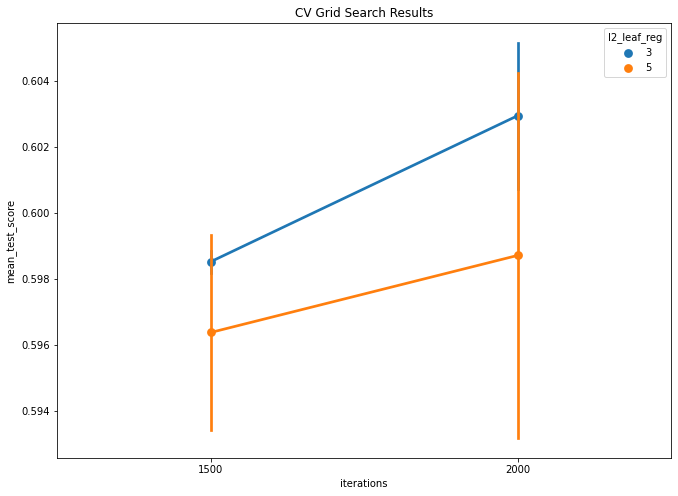

In [49]:
# Оптимальное значение регуляризации
plot_cv_results(cat_results, 'iterations', 'l2_leaf_reg');

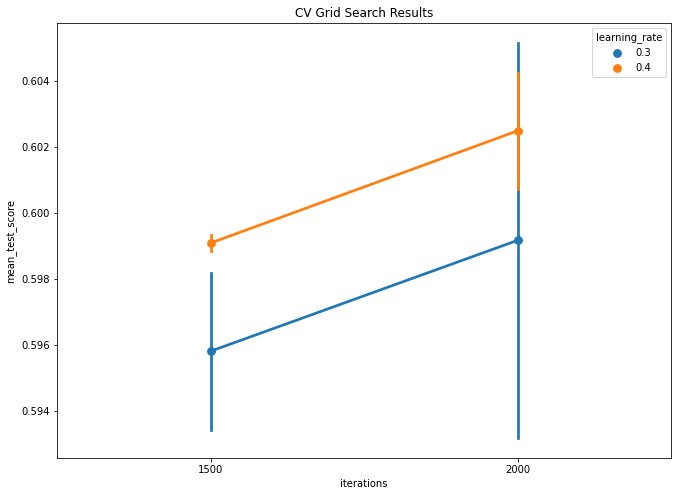

In [50]:
# Оптимальное значение регуляризации
plot_cv_results(cat_results, 'iterations', 'learning_rate');

In [69]:
np.where(cat_df.dtypes != np.float)[0]

array([9])

In [71]:
# https://www.youtube.com/watch?v=xl1fwCza9C8

model_cb = CatBoostClassifier(
    random_state=RANDOM_SEED,
    use_best_model=True,
    # early_stopping_rounds=100,
    bagging_temperature=1,
    iterations=2000,
    l2_leaf_reg=3,
    leaf_estimation_method='Newton',
    learning_rate=0.3,
    one_hot_max_size=2,
    random_strength=1,
    eval_metric='F1',
    custom_loss=['F1', 'Precision', 'Recall']
)

X_train, X_test, y_train, y_test = train_test_split(
    cat_df, y_1_bin, test_size=0.2, random_state=RANDOM_SEED
)

model_cb.fit(
    X_train, y_train,
    cat_features=np.where(X_train.dtypes != np.float)[0],
    eval_set=(X_test, y_test),
    verbose=False,
    plot=True
)

print(json.dumps(model_cb.best_score_, indent=4, sort_keys=True))
print('Количество деревьев в модели', model_cb.tree_count_)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

{
    "learn": {
        "F1": 0.9983424106085721,
        "Logloss": 0.09820491707147032,
        "Precision": 0.9995257666772052,
        "Recall": 0.9973190348525469
    },
    "validation": {
        "F1": 0.6077834179357021,
        "Logloss": 0.6123723677922407,
        "Precision": 0.6482449589245706,
        "Recall": 0.5744408945686901
    }
}
Количество деревьев в модели 1955


## Ансамбли методов

In [63]:
def stack(X, y, test_size):
    """Стэкинг моделей
    """
    # Hold-out разбиение датасета
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=RANDOM_SEED
    )
    
    categorical_features_indices = np.where(X_train.dtypes != np.float)[0]

    estimators = [
        ('cat', CatBoostClassifier(
            random_state=RANDOM_SEED, silent=True,
            bagging_temperature=1,
            iterations=2000,
            l2_leaf_reg=3,
            leaf_estimation_method='Newton',
            learning_rate=0.3,
            one_hot_max_size=2,
            random_strength=1,
            eval_metric='F1',
            cat_features=categorical_features_indices
            )
        ),
        
        ('lgb', LGBMClassifier(random_state=RANDOM_SEED)),
        
        ('rf', RandomForestClassifier(
            random_state=RANDOM_SEED,
            min_samples_split=2,
            min_samples_leaf=1,
            n_estimators=1000
            )
        )
    ]

    model_stack = StackingClassifier(
        estimators=estimators,
        final_estimator=None
    )

    model_stack.fit(X_train, y_train)
    y_pred = model_stack.predict(X_test)
    error = f1_score(y_test, y_pred)

    print('F1-score:', error)

In [64]:
stack(X_best, y_1_bin, 0.2)

F1-score: 0.6168876482903
